# **[Project] Cancer Subtype Classification**

# Introduction

The [TCGA Kidney Cancers Dataset](https://archive.ics.uci.edu/dataset/892/tcga+kidney+cancers) is a bulk RNA-seq dataset that contains transcriptome profiles (i.e., gene expression quantification data) of patients diagnosed with three different subtypes of kidney cancers.
This dataset can be used to make predictions about the specific subtype of kidney cancers given the normalized transcriptome profile data.

The normalized transcriptome profile data is given as **TPM** and **FPKM** for each gene.

> TPM (Transcripts Per Million) and FPKM (Fragments Per Kilobase Million) are two common methods for quantifying gene expression in RNA sequencing data.
> They both aim to account for the differences in sequencing depth and transcript length when estimating gene expression levels.
>
> **TPM** (Transcripts Per Million):
> - TPM is a measure of gene expression that normalizes for both library size (sequencing depth) and transcript length.
> - The main idea behind TPM is to express the abundance of a transcript relative to the total number of transcripts in a sample, scaled to one million.
>
> **FPKM** (Fragments Per Kilobase Million):
> - FPKM is another method for quantifying gene expression, which is commonly used in older RNA-seq analysis pipelines. It's similar in concept to TPM but differs in the way it's calculated.
> - FPKM also normalizes for library size and transcript length, but it measures gene expression as the number of fragments (i.e., reads) per kilobase of exon model per million reads.
>
> TPM is generally considered more robust to variations in library size, making it a preferred choice in many modern RNA-seq analysis workflows.

We provide one dataset for each kidney cancer subtype:

- [TCGA-KICH](https://portal.gdc.cancer.gov/projects/TCGA-KICH): kidney chromophobe (renal clear cell carcinoma)
- [TCGA-KIRC](https://portal.gdc.cancer.gov/projects/TCGA-KIRC): kidney renal clear cell carcinoma
- [TCGA-KIRP](https://portal.gdc.cancer.gov/projects/TCGA-KIRP): kidney renal papillary cell carcinoma

> This and _much_ more data is openly available on the [NCI Genomic Data Commons (GDC) Data Portal](https://portal.gdc.cancer.gov/).

# Data access

There are two ways to access the data: via the TNT homepage or the GDC Data Portal.

## Download from the TNT homepage (_recommended_)

The download from the TNT homepage is straightforward:

In [ ]:
# ! wget http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/project-cancer-classification.tar.gz
# ! tar -xzvf project-cancer-classification.tar.gz
# ! mv -v project-cancer-classification/ data/
# ! rm -v project-cancer-classification.tar.gz

In the `data/` folder you will now find many files in the [TSV format](https://en.wikipedia.org/wiki/Tab-separated_values) ([CSV](https://en.wikipedia.org/wiki/Comma-separated_values)-like with tabs as delimiter) containing the normalized transcriptome profile data.

To start, you can read a TSV file into a [pandas](https://pandas.pydata.org) [`DataFrame`](pandas dataframe to dict) using the [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv) function with the `sep` parameter set to `\t`:

## ML Pipeline (Data Preprocessing, Data Visualization, Feature Selection, Algorithm Selection, Hyperparameter Optimization)

Our ML pipeline includes the following necessary steps:
1. Data Preprocessing & Visualization: Understand the data & Preprocess it in a useful format
2. Feature Selection: Select the most important features
3. Algorithm Selection: Select the ML algorithm
4. Hyperparameter Optimization: Optimize the hyperparameter of the ML algorithm

## Data Preprocessing & Visualization

Before we applying some ML algorithms, we have to preprocess our data into numerical/categorical values so that the ML algorithms can handle these values.

Each sample contains the following multiple rows:
 - **gene_id:** Id of the specific gene
 - **gene_name:** Name of the specific gene
 - **gene_type:** Type of the specific gene
 - **unstranded:** Unstranded expression values for the corresponding gene
 - **stranded_first:** Expression values for the first (sense) strand of the gene
 - **stranded_second:** Expression values for the second (antisense) strand of the gene
 - **tpm_unstranded:** Transcripts per Million
 - **fpkm_unstranded:** Fragments per Kilobase of transcript per Million mapped reads
 - **fpkm_uq_unstranded:** Upper quartile fragments per Kilobase of transcripts per Million mapped reads
 - **class_index:** The label of the corresponding subtype of kidney cancer and columns

We suppose to use **tpm_unstranded** for further analysis.

The following example shows how each sample is constructed:

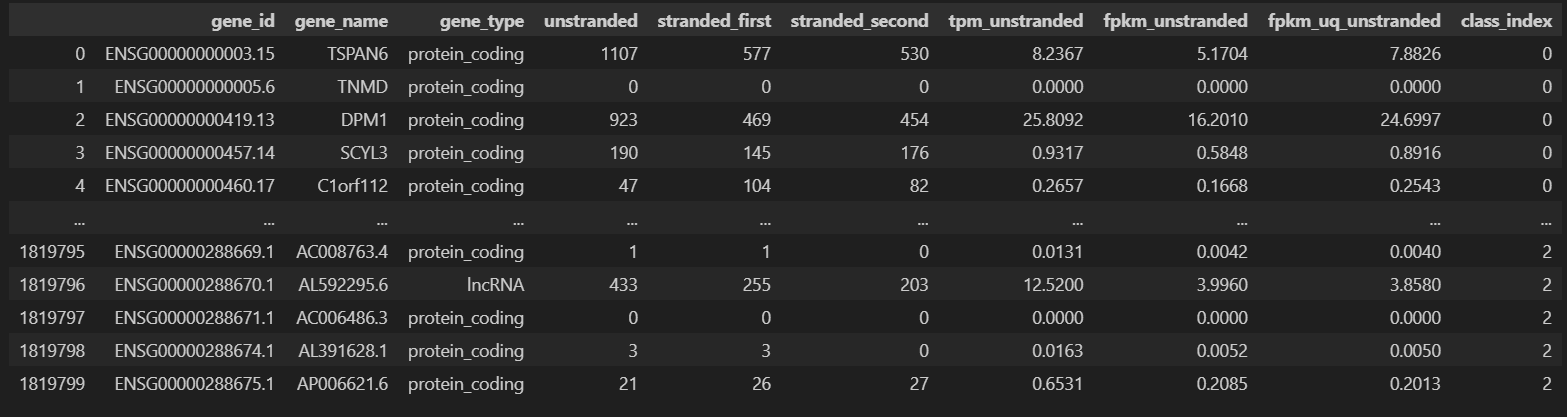

In [173]:
from typing import Optional
import pandas as pd
import glob
import os

def load_profile_data(file_path: str, remove_header: bool = True) -> pd.DataFrame:
    """
    Loads a specific RNA-sequence data (one sample).

    Args:
        file_path (str):
            Specific path of the file

        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed

    Returns:
        pd.DataFrame:
            RNA-sequence data of one sample
    """
    
    # Read the TSV file into a DataFrame
    df = pd.read_csv(filepath_or_buffer=file_path, sep="\t")
    
    # Remove Multi-Key Index and make it tabular
    df.reset_index(inplace=True)

    # Rename the new columns level_i into the corresponding columns
    df.rename(columns={
        "level_0": "gene_id",
        "level_1": "gene_name",
        "level_2": "gene_type",
        "level_3": "unstranded",
        "level_4": "stranded_first",
        "level_5": "stranded_second",
        "level_6": "tpm_unstranded",
        "level_7": "fpkm_unstranded",
        "# gene-model: GENCODE v36": "fpkm_uq_unstranded",
    }, inplace=True)

    # Remove the first row
    df = df.iloc[1:]
    
    # Change the dtypes of specific columns
    df["unstranded"] = df["unstranded"].astype(int)
    df["stranded_first"] = df["stranded_first"].astype(int)
    df["stranded_second"] = df["stranded_second"].astype(int)
    df["tpm_unstranded"] = df["tpm_unstranded"].astype(float)
    df["fpkm_unstranded"] = df["fpkm_unstranded"].astype(float)
    df["fpkm_uq_unstranded"] = df["fpkm_uq_unstranded"].astype(float)
    
    if remove_header:
        # Case: Remove the header rows
        df = df.iloc[4:]
    
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    return df

def simplify_dataset(
    df: pd.DataFrame, 
    categorical_column: str = "gene_name",
    continuous_column: str = "tpm_unstranded",
    n_genes: int = 60660,
) -> pd.DataFrame:
    """
    Simplifies the dataset by removing all columns except the given continuous column
    and renames each column by the categorical column.

    Args:
        df (pd.DataFrame):
            The dataframe we want to simplify
        
        categorical_column (str, optional):
            The labels of the new columns
        
        continuous_column (str, optional): 
            The column we want to keep
        
        n_genes (int, optional):
            The number of genes we want to keep (60660 := all genes)

    Returns:
        pd.DataFrame: _description_
    """
    assert 1 <= n_genes <= 60660, f"Illegal n_genes {n_genes}. The argument should be higher or equal to 1!"
    
    # Transpose the given (N, 1) dataset to (1, N)
    new_df =  pd.DataFrame(df[continuous_column][:n_genes])
    new_df = new_df.transpose()
    
    # Rename the columns to the new ones
    new_df.columns = df[categorical_column][:n_genes].to_numpy()
    
    # Reset the indices
    new_df.reset_index(drop=True, inplace=True)
    return new_df

def load_cancer_classification_dataset(
    data_path: str, 
    continuous_column: str = "tpm_unstranded",
    n_genes: int = 60660,
    remove_header: bool = True,
    n_samples: Optional[int] = None,
) -> pd.DataFrame:
    """
    Loads the entire cancer classification dataset.

    Args:
        data_path (str):
            Specific path of the dataset
        
        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed for each instance
        
        n_samples (int, optional): 
            Number of instances for each class
    
    Returns:
        pd.DataFrame:
            Cancer classification dataset
    """
    datasets = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]
    tsv_files = []
    dfs = []
    ys = []
    root_dir = os.path.join(os.getcwd(), data_path)

    # Get the paths of all tsv files
    for i, dataset in enumerate(datasets):
        dataset_path = os.path.join(root_dir, dataset)
        paths = glob.glob(os.path.join(dataset_path, "*/*.tsv"))
        
        if n_samples:
            tsv_files += paths[:n_samples]
            ys += [i] * len(paths[:n_samples])
        else:
            tsv_files += paths
            ys += [i] * len(paths)

    # Load the data from all tsv files
    for i, tsv_file in enumerate(tsv_files):
        df = load_profile_data(tsv_file, remove_header)
        df = simplify_dataset(df, continuous_column=continuous_column, n_genes=n_genes)
        df["class_index"] = [ys[i]] * len(df)  # Add class index to each row
        df["class_index"] = df["class_index"].astype(int)
        dfs += [df]
    
    # Concatenate each df together to a dataset
    dataset = pd.concat(dfs, ignore_index=True)
    return dataset

In [175]:
from sklearn.decomposition import PCA
from ConfigSpace import Configuration
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_matrix(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    colors: list[str] = ["tab:blue", "tab:red", "tab:orange"],
    figsize: tuple[int, int] = (10, 10),
    bins: int = 30,
    alpha: float = 0.3
):
    """
    Plots the scatter matrix across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        colors (list[str], optional):
            The colors between the different class index
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        bins (int, optional):
            Number of bins for the histogram
        
        alpha (float, optional):
            Transparency level
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)

    # Create a scatter matrix plot
    fig, ax = plt.subplots(X.shape[1], X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            
            if X.shape[1] == 1:
                cur_ax = ax
            else:
                cur_ax = ax[i][j]
                
            if j == 0:
                cur_ax.set_ylabel(columns[i])

            if i == X.shape[1] - 1:
                cur_ax.set_xlabel(columns[j])

            if i == j:
                for y_ in y_unique:
                    cur_ax.hist(X[y == y_, i], bins=bins, label=labels[y_], color=colors[y_], alpha=alpha)
            else:
                for y_ in y_unique:
                    cur_ax.scatter(X[y == y_, j], X[y == y_, i], label=labels[y_], color=colors[y_], alpha=alpha)
            cur_ax.legend(loc="upper right")
    plt.show()

def plot_boxplot(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    colors: list[str] = ["tab:blue", "tab:red", "tab:orange"],
    figsize: tuple[int, int] = (20, 20),
):
    """
    Plots the boxplots across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        colors (list[str], optional):
            The colors between the different class index
        
        figsize (tuple[int, int], optional):
            Size of the figure
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"

    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)
    
    fig, ax = plt.subplots(X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        if X.shape[1] == 1:
            cur_ax = ax
        else:
            cur_ax = ax[i]
        
        cur_ax.set_ylabel(columns[i])
        
        splits = [X[y == y_, i] for y_ in y_unique]
        boxplot = cur_ax.boxplot(splits, labels=labels, vert=True, patch_artist=True)
        
        # Set custom colors for each box
        for box, color in zip(boxplot["boxes"], colors):
            box.set_facecolor(color)
        
        # Set the median line to black for each box
        plt.setp(boxplot["medians"], color="black")
        
    plt.show()

def plot_cumulative_variance_ratio(
    X: np.ndarray,
    y: np.ndarray,
    color: str = "tab:blue",
    figsize: tuple[int, int] = (20, 20)
) -> np.ndarray:
    """
    Plots the cumulative variance ratio from the PCA component, to decide how many components do we choose.
    Additionally it returns the cumulative variance ratio from the PCA component.

    Args:
         X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        color (str, optional):
            The color of the curve
            
        figsize (tuple[int, int], optional):
            Size of the figure
    
    Returns:
        np.ndarray:
            The cumulative variance ratio from PCA
    """
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    # Initialize the PCA
    pca = PCA(n_components=min(X.shape[0], X.shape[1]))

    # Transform the data
    pca.fit(X)

    # Plot the cumulative variance ratio to how many components should be used
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    plt.subplots(figsize=figsize)
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, color=color)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.show()
    
    return cumulative_variance_ratio

def plot_incumbent_improvement(
    history: list[tuple[Configuration, float]],
    color: str = "tab:blue",
    figsize: tuple[float, float] = (20, 20),
):
    """
    Plots the improvement of the incumbent as a curve.

    Args:
        history (list[tuple[Configuration, float]]):
            The history of an AutoML Tool, where each entry i = (cfg_i, val_acc_i)
            contains the evaluated configuration and its validation accuracy
        
        color (str, optional):
            The color of the curve
        
        figsize (tuple[int, int], optional):
            Size of the figure
    """
    # Compute the incumbent improvment
    incumbent_improvement = []
    incumbent_acc = -np.inf
    for _, acc in history:
        if acc > incumbent_acc:
            incumbent_acc = acc
        incumbent_improvement += [incumbent_acc]
    x = [i for i in range(len(history))]
    
    plt.subplots(figsize=figsize)
    plt.step(x, incumbent_improvement, color=color)
    plt.xlabel("Number of configuration")
    plt.ylabel("Validation accuracy")
    plt.show()

def plot_learning_curve(
    training_losses: np.ndarray,
    color: str = "tab:blue",
    figsize: tuple[int, int] = (20, 20),
):
    """
    Plots the learning curve of an Neural Network based model.

    Args:
        training_losses (np.ndarray):
            The training losses over each epoch
        
        color (str, optional): 
            The color of the curve
        
        figsize (tuple[int, int], optional):
            Size of the figure
    """
    x = [i for i in range(len(training_losses))]
    
    plt.subplots(figsize=figsize)
    plt.step(x, training_losses, color=color)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")
    plt.show()

In [176]:
# Example: Load one sample (tsv file) of the dataset
df = load_profile_data("data/tcga-kich-geq/00ddf8c2-039f-409f-a2ed-b29e18395dd4/f07b7c4c-5f30-4c51-9eb1-4f873ad49c56.rna_seq.augmented_star_gene_counts.tsv")
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,ENSG00000000003.15,TSPAN6,protein_coding,1107,577,530,8.2367,5.1704,7.8826
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000
2,ENSG00000000419.13,DPM1,protein_coding,923,469,454,25.8092,16.2010,24.6997
3,ENSG00000000457.14,SCYL3,protein_coding,190,145,176,0.9317,0.5848,0.8916
4,ENSG00000000460.17,C1orf112,protein_coding,47,104,82,0.2657,0.1668,0.2543
...,...,...,...,...,...,...,...,...,...
60655,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000
60656,ENSG00000288670.1,AL592295.6,lncRNA,195,83,126,3.6421,2.2863,3.4856
60657,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000
60658,ENSG00000288674.1,AL391628.1,protein_coding,1,0,1,0.0035,0.0022,0.0034


In [177]:
# Example: For further analysis we only use the column "tpm_unstranded"
df = simplify_dataset(df, continuous_column=["tpm_unstranded"])
df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AL451106.1,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6
0,8.2367,0.0,25.8092,0.9317,0.2657,2.9539,1.4042,15.7151,4.5194,4.924,...,0.0,0.0,0.1066,0.0,0.0,0.0,3.6421,0.0,0.0035,0.7835


## Data Preprocessing

In principle we have different options to reduce the number of genes used for our ML model
1. Do no preprocessing and stay with 60660 genes.
2. Take the first $N$ genes.
3. Use PCA to reduce the dimensionality to $N$ genes.

In [178]:
# Represents the 1. option (do nothing)
# Load 100 samples (tsv files) from each class, concatenates them into a dataset (~ 5 min.)
df = load_cancer_classification_dataset("data", continuous_column="tpm_unstranded", n_genes=60660, n_samples=100)
df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,class_index
0,8.2367,0.0000,25.8092,0.9317,0.2657,2.9539,1.4042,15.7151,4.5194,4.9240,...,0.0000,0.1066,0.0,0.0000,0.0000,3.6421,0.0,0.0035,0.7835,0
1,4.0204,0.1582,16.6135,0.5691,0.1217,1.4957,0.1268,10.0106,3.0583,2.1101,...,0.0000,0.2003,0.0,0.0000,0.0000,2.4549,0.0,0.0944,0.4324,0
2,30.3101,0.0000,194.5276,4.1172,4.2266,9.3357,11.7886,63.2781,8.2357,61.3211,...,0.0000,0.5563,0.0,0.0000,0.0000,10.8131,0.0,0.0336,1.5405,0
3,192.6733,2.2687,166.1158,13.8005,2.6671,9.7596,9.5741,62.3076,7.1604,30.2865,...,0.0000,0.1799,0.0,0.0000,0.0000,11.7993,0.0,0.2841,0.5695,0
4,29.3118,0.2938,56.6818,1.8314,0.4773,0.5403,0.5084,25.3080,5.7213,5.0955,...,0.5162,0.1739,0.0,0.0000,0.0000,6.1702,0.0,0.0129,0.1659,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,32.6709,0.0498,59.5020,5.9273,1.6992,19.5185,141.5843,86.3777,16.5648,20.8319,...,0.0000,1.2641,0.0,1.2051,0.0184,20.6657,0.0,0.0153,0.6563,2
287,64.0202,0.6547,110.7745,4.2120,1.5493,3.6942,44.8847,105.3012,18.5983,42.7455,...,1.1504,0.2544,0.0,0.0000,0.0000,20.7042,0.0,0.0072,0.8217,2
288,37.5658,0.0775,65.9701,3.9447,0.9000,16.4622,26.0880,84.5066,18.6448,24.3285,...,0.0000,0.5216,0.0,0.0000,0.0000,18.2841,0.0,0.0475,0.9527,2
289,17.8522,0.0361,20.1535,0.6820,0.1296,3.2414,0.1805,51.0293,4.5248,3.9683,...,0.0000,0.0187,0.0,0.0000,0.0000,6.2437,0.0,0.0000,0.5398,2


In [192]:
# Name of the different class labels / columns
labels = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]
columns = df.columns

# Define X (feature matrix) and y (true outputs)
X = df.iloc[:, :-1].to_numpy()
y = df["class_index"].to_numpy()
X.shape, y.shape

((291, 60660), (291,))

In [180]:
# Represents the 2. option (only take the first N=100 genes)
N = 100
X = X[:, :N]
y = y
X.shape, y.shape

((291, 100), (291,))

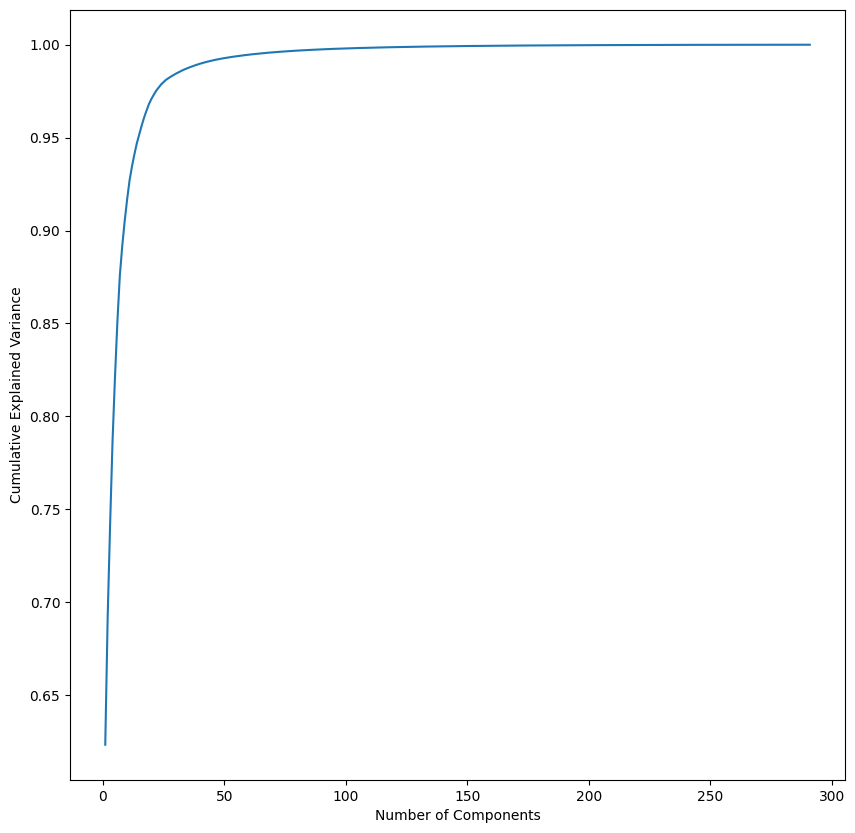

In [193]:
# Represents the 3. option (using PCA to reduce the dimensionality)
# First plot the cumulative variance ratio to decide the value of n_components=...
cumulative_variance_ratio = plot_cumulative_variance_ratio(X, y, figsize=(10, 10))

In [194]:
# Lets take the number of components where we have a cumulative variance ratio of 99.9% (~133 components)
treshold = 0.999
n_components = None
for i, cvr in enumerate(cumulative_variance_ratio):
    if cvr >= treshold:
        n_components = i + 1
        break
print(f"n_components={n_components}")

n_components=133


In [195]:
# Lets perform PCA with the calculated n_components
X = PCA(n_components=n_components).fit_transform(X)

## Data Visualization

We can visualize the data and looking into the distribution of tpm_unstranded values of each gene by plotting a scatter matrix or a boxplot.
For simplicity we only plot the scatter matrix and boxplots for the first $N$ genes.

In [101]:
# Plot the scatter matrix plot
N_gene_visualize = 5
plot_scatter_matrix(X[:, :N_gene_visualize], y, labels, columns[:N_gene_visualize], figsize=(100, 100))

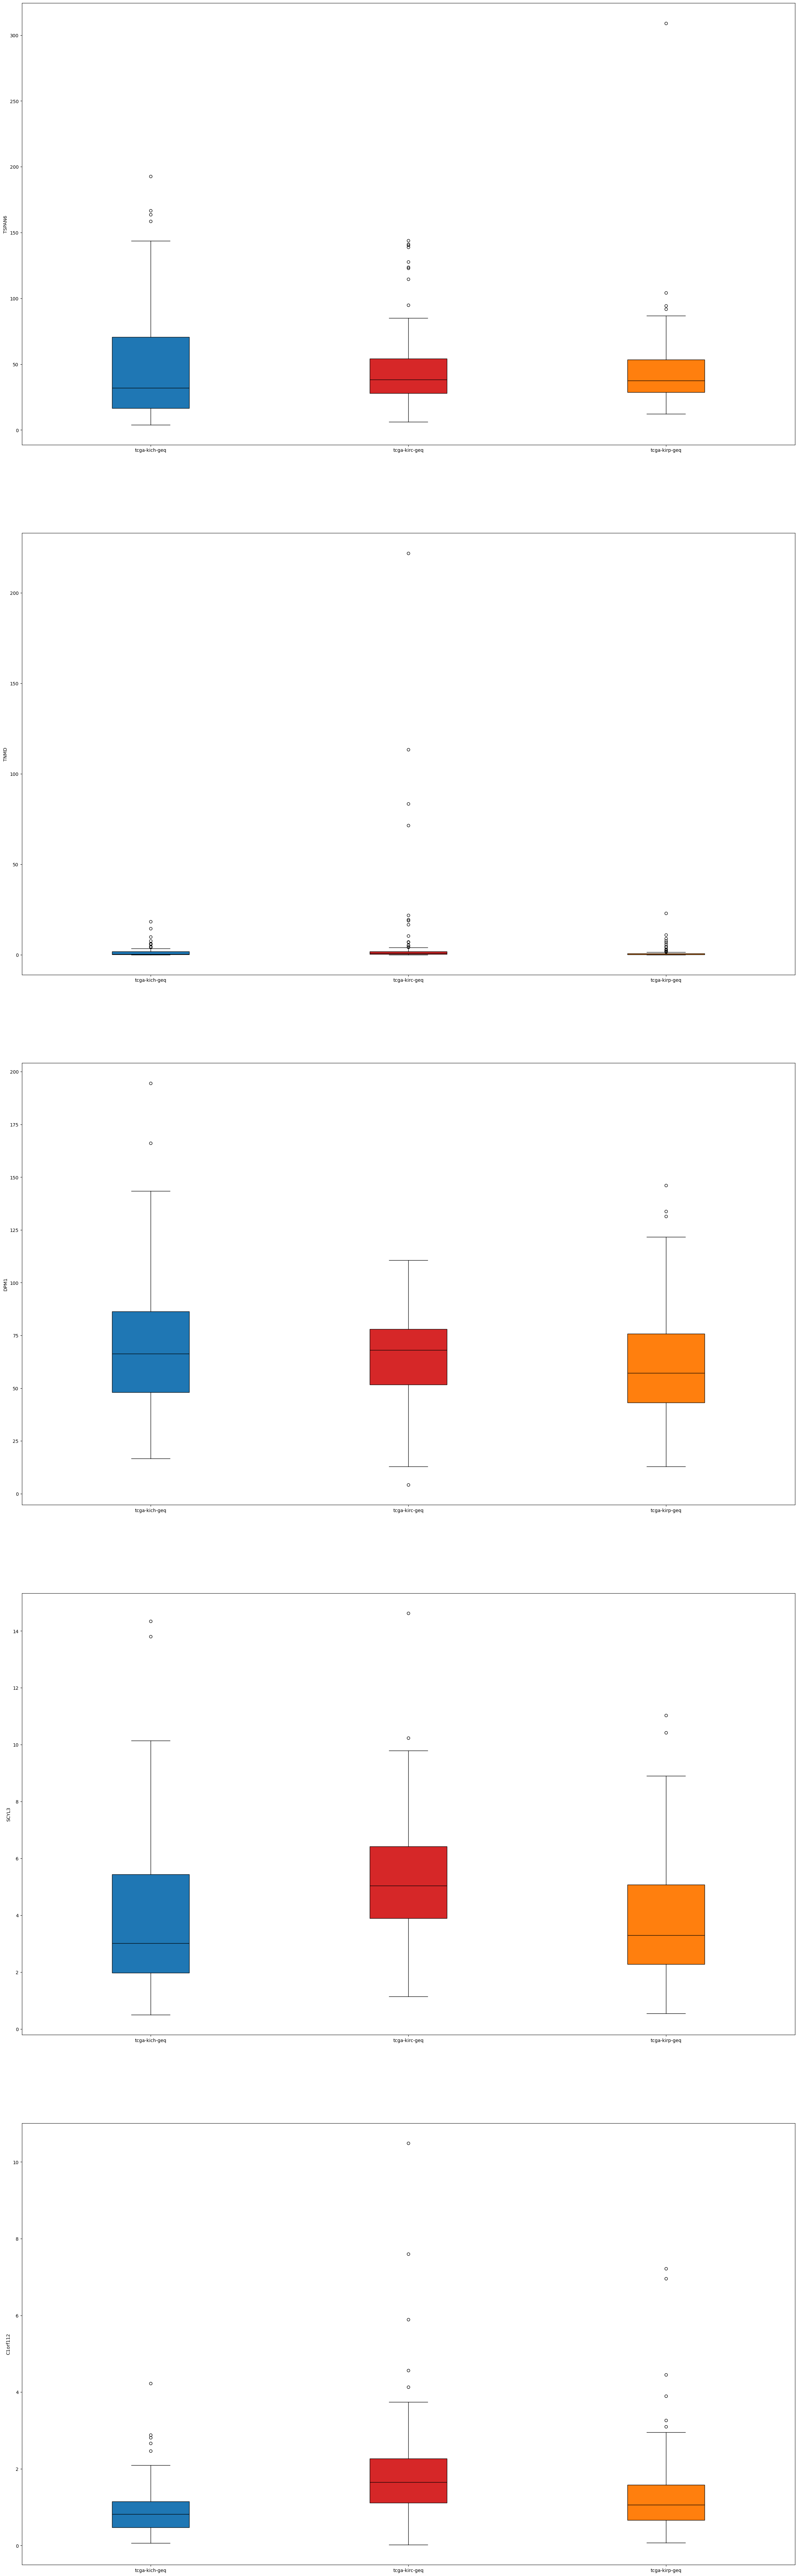

In [102]:
# Plot the boxplot for each gene between different classes
plot_boxplot(X[:, :N_gene_visualize], y, labels, columns[:N_gene_visualize], figsize=(30, 100))

## Algorithm Selection & Training

First lets start with a Random Forest Classifier and see if it can classify the kidney cancer subtypes correctly.

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from ConfigSpace import ConfigurationSpace
from typing import Type

def eval_model(
    model: BaseEstimator,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3, 
    random_state: int = 0
) -> float:
    """
    Evaluates a given Classifier, by K-Fold cross validation (CV).

    Args:
        model (BaseEstimator): 
            The classifier we want to evaluate
            
        X (np.ndarray):
            The feature vector of shape (N, ?)
            
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        random_state (int, optional):
            Random Seed for reproducibility

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, val_idx in kf.split(X):
        
        # Get the train/test dataset
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_val)
        score = balanced_accuracy_score(y_true=y_val, y_pred=y_pred)
        scores += [score]
    return np.mean(scores)

def eval_configuration(
    model_cls: Type[BaseEstimator],
    cfg: Configuration,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3,
    random_state: int = 1,
) -> float:  
    """
    Evaluates a configuration (:= set of hyperparameters) to a given model class, by K-Fold cross validation (CV).

    Args:
        model_cls (Type[BaseEstimator]):
            The model class (:= classifier) we want to use
            
        cfg (Configuration):
            The configuration we want to evaluate
        
        X (np.ndarray):
            The feature vector of shape (N, ?)

        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        random_state (int, optional):
            Random Seed for reproducibility

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    model = model_cls(**cfg, random_state=random_state)
    return eval_model(model, X, y, n_splits=n_splits, random_state=random_state)

def random_search(
    cs: ConfigurationSpace,
    X: np.ndarray,
    y: np.ndarray,
    n_cfgs: int = 50
) -> tuple[Configuration, list[tuple[Configuration, float]]]:
    """
    Performs Random Search for finding the best configuration.

    Args:
        cs (ConfigurationSpace):
            The configuration space from where we sample
        
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_cfgs (int, optional):
            The number of configuration we want to evaluate/sample
    
    Returns:
        Configuration:
            The best configuration across the sampled configurations
    """
    assert n_cfgs >= 1, f"Illegal n_cfgs {n_cfgs}. The argument should be higher or equal to 1!"
    
    if n_cfgs == 1:
        cfgs = [cs.sample_configuration()]
    else:
        cfgs = cs.sample_configuration(n_cfgs)
    
    scores = []
    history = []
    model_cls = cs.meta["model_class"]
    n_splits = cs.meta["n_splits"]
    random_state = cs.meta["random_state"]
    
    for cfg in cfgs:
        score = eval_configuration(model_cls, cfg, X, y, n_splits, random_state)
        scores += [score]
        history += [(cfg, score)]
    return cfgs[np.argmax(scores)], history

In [197]:
from ConfigSpace import Integer, Categorical

# Initialize the Configuration Space
random_state = 0
cs = ConfigurationSpace(
    seed=random_state,
    space={
        "n_estimators": Integer("n_estimators", bounds=(10, 30), default=20),
        "criterion": Categorical("criterion", items=["gini", "entropy", "log_loss"], default="gini"),
        "max_depth": Integer("max_depth", bounds=(1, 30), default=10),
        "min_samples_split": Integer("min_samples_split", bounds=(2, 10), default=2),
        "min_samples_leaf": Integer("min_samples_leaf", bounds=(1, 10), default=1),
        "max_features": Categorical("max_features", items=["sqrt", "log2"], default="sqrt"),
    },
    meta={
        "model_class": RandomForestClassifier,
        "n_splits": 3,
        "random_state": random_state,
    }
)

In [198]:
from sklearn.model_selection import train_test_split

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [199]:
# Do Random Search (~ 1 min.)
best_cfg, history = random_search(cs, X_train, y_train, n_cfgs=100)
best_cfg

Configuration(values={
  'criterion': 'gini',
  'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 4,
  'n_estimators': 30,
})

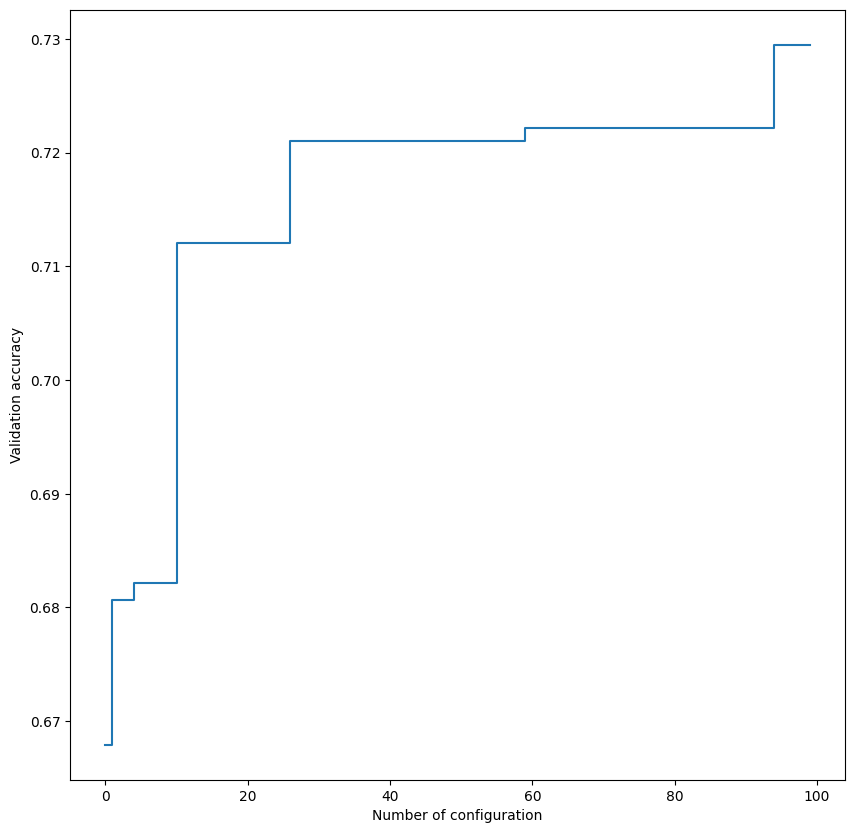

In [200]:
# Plot the incumbent improvement
plot_incumbent_improvement(history, figsize=(10, 10))

In [201]:
# Initialize the model
model = RandomForestClassifier(**best_cfg, random_state=random_state)

# Train the model
model.fit(X_train, y_train)

# Get the accuracy of the model
y_pred = model.predict(X_test)

In [202]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Print the balanced accuracy, f1_score and roc_auc_score
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")

print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")
print(f"F1 Score: {f1}")

Accuracy Score: 0.6949152542372882
Balanced Accuracy Score: 0.7126470021206863
F1 Score: 0.6943754796711883


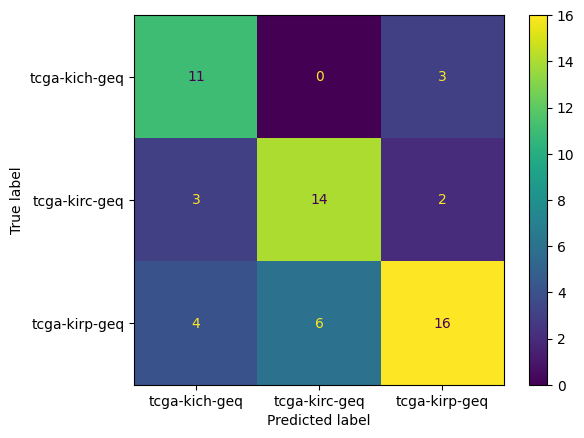

In [203]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=labels)

Lets try out to use a Neural Network model instead of using Random Forest.

In [204]:
from torch.utils.data import DataLoader, TensorDataset
from typing import Union
import torch.nn as nn
import torch

class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_hidden_layers: int,
        act_fn_type: str,
        loss_fn_type: str,
        optimizer_fn_type: str,
        lr: float,
        batch_size: int,
        n_epochs: int,
        random_state: int,
    ):
        # Sets the random state for pytorch / numpy
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        super().__init__()
        layers = []  # list of all modules (including activation functions)
        act_fn_cls = self.get_act_fn(act_fn_type)  # class of activation function to use
        loss_fn_cls = self.get_loss_fn(loss_fn_type)  # class of loss function to use
        optimizer_fn_cls = self.get_optimizer_fn(optimizer_fn_type)  # class of optimizer to use

        if n_hidden_layers >= 1:
            # Case: There exist at least one hidden layer
            layer = nn.Linear(input_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        for _ in range(n_hidden_layers - 1):
            # Case: Insert the other n-1 hidden layer
            layer = nn.Linear(hidden_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        if n_hidden_layers >= 1:
            # Case: At least one hidden layer was used
            layers += [nn.Linear(hidden_dim, output_dim)]
        else:
            # Case: Not hidden layers are used
            layers += [nn.Linear(input_dim, output_dim)]
        
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.model = nn.Sequential(*layers)
        self.loss_fn = loss_fn_cls()
        self.optimizer = optimizer_fn_cls(params=self.model.parameters(), lr=lr)
    
    def forward(self, X: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        The forward pass of the MLP model.

        Args:
            X (Union[np.ndarray, torch.Tensor]):
                The feature matrix (X)
        
        Returns:
            torch.Tensor:
                The predicted probability distribution for each class (y_logits)
        """
        if isinstance(X, np.ndarray):
            X_ = torch.from_numpy(X).to(dtype=torch.float32)
        else:
            X_ = X
        return self.model.forward(X_)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Trains the MLP model for a given number of epochs.

        Args:
            X (np.ndarray):
                Feature matrix for training (X_train)
            
            y (np.ndarray):
                Labels vector for training (y_train)
        
        Returns:
            np.ndarray:
                training losses over each epochs
        """
        self.model.train()

        # Create DataLoader for (mini-)batch training
        X_train = torch.from_numpy(X).to(dtype=torch.float32)
        y_train = torch.from_numpy(y).to(dtype=torch.int64)
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
        train_losses = []
        
        for _ in range(self.n_epochs):
            running_loss = 0.0
            n = 0
            for _, (inputs, targets) in enumerate(dataloader):
                # Zero your gradients for every batch
                self.optimizer.zero_grad()
                
                # Make predictions for this batch
                outputs = self.model.forward(inputs)
                
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                
                # Adjust learning weights
                self.optimizer.step()
                
                # Update running loss and number of batches
                running_loss += loss.item()
                n += 1
            
            # Compute loss of i-th epoch
            epoch_loss = running_loss / n
            # print(f"Epoch {i+1}: {epoch_loss}")
            train_losses += [epoch_loss]
        return np.array(train_losses)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the class labels, given new data points.

        Args:
            X (np.ndarray):
                The feature matrix of new unseen data points (X_test)

        Returns:
            np.ndarray:
                The predicted class labels (y_pred)
        """
        self.model.eval()
        
        # Get the probability distribution over each class
        y_pred = self.forward(X)
        
        # Convert logits to probability distribution
        y_pred = y_pred.softmax(dim=1)
        
        # Select the class with the highest probability
        y_pred = y_pred.argmax(dim=1)
        
        # Convert to numpy array
        y_pred = y_pred.detach().cpu().numpy()
        
        return y_pred
    
    def get_act_fn(self, act_fn_type: str) -> Type[nn.Module]:
        """
        Returns the activation function (for each layer), given the type.

        Args:
            act_fn_type (str):
                The type of the activation function

        Returns:
            Type[nn.Module]:
                The class of the activation function
        """
        act_fns = {
            "relu": nn.ReLU,
            "sigmoid": nn.Sigmoid,
            "tanh": nn.Tanh,
        }
        if act_fn_type not in act_fns:
            raise ValueError(f"Unknown act_fn_type {act_fn_type}!")
        else:
            return act_fns[act_fn_type]
    
    def get_loss_fn(self, loss_fn_type: str) -> Type[nn.Module]:
        """
        Returns the loss function class, given the type.

        Args:
            loss_fn_type (str):
                Type of the loss function as string

        Returns:
            Type[nn.Module]:
                The class of the Loss function
        """
        loss_fns = {
            "ce": nn.CrossEntropyLoss,
        }
        if loss_fn_type not in loss_fn_type:
            raise ValueError(f"Unknown loss_fn_type {loss_fn_type}!")
        return loss_fns[loss_fn_type]

    def get_optimizer_fn(self, optimizer_fn_type: str) -> Type[torch.optim.Optimizer]:
        """
        Returns the optimizer class, given the type.

        Args:
            optimizer_fn_type (str):
                Type of the optimizer class as string

        Returns:
            Type[torch.optim.Optimizer]:
                The class of the optimizer
        """
        optimizer_fns = {
            "adam": torch.optim.Adam,
            "adamw": torch.optim.AdamW,
            "sgd": torch.optim.SGD,
            "rmsprop": torch.optim.RMSprop,
        }
        if optimizer_fn_type not in optimizer_fns:
            raise ValueError(f"Unknown optimizer_fn_type {optimizer_fn_type}!")
        return optimizer_fns[optimizer_fn_type]

In [205]:
from ConfigSpace import Float, Constant

# Initialize the Configuration Space
cs = ConfigurationSpace(
    seed=random_state,
    space={
        "input_dim": Constant("input_dim", value=X.shape[1]),
        "hidden_dim": Integer("hidden_dim", bounds=(16, 64), default=32),
        "output_dim": Constant("output_dim", value=3),
        "n_hidden_layers": Integer("n_hidden_layers", bounds=(0, 5), default=3),
        "act_fn_type": Categorical("act_fn_type", items=["relu", "sigmoid", "tanh"], default="relu"),
        "loss_fn_type": Constant("loss_fn_type", value="ce"),
        "optimizer_fn_type": Categorical("optimizer_fn_type", items=["adam", "adamw", "sgd", "rmsprop"], default="adam"),
        "lr": Float("lr", bounds=(1e-5, 1e-2), default=1e-3),
        "batch_size": Integer("batch_size", bounds=(16, 64), default=32),
        "n_epochs": Constant("n_epochs", value=200),
    },
    meta={
        "model_class": MLP,
        "n_splits": 3,
        "random_state": random_state,
    }
)

In [206]:
# Do Random Search (~ 35 min.)
best_cfg, history = random_search(cs, X_train, y_train, n_cfgs=100)
best_cfg

Configuration(values={
  'act_fn_type': 'tanh',
  'batch_size': 30,
  'hidden_dim': 26,
  'input_dim': 133,
  'loss_fn_type': 'ce',
  'lr': 0.006959298201932184,
  'n_epochs': 200,
  'n_hidden_layers': 0,
  'optimizer_fn_type': 'rmsprop',
  'output_dim': 3,
})

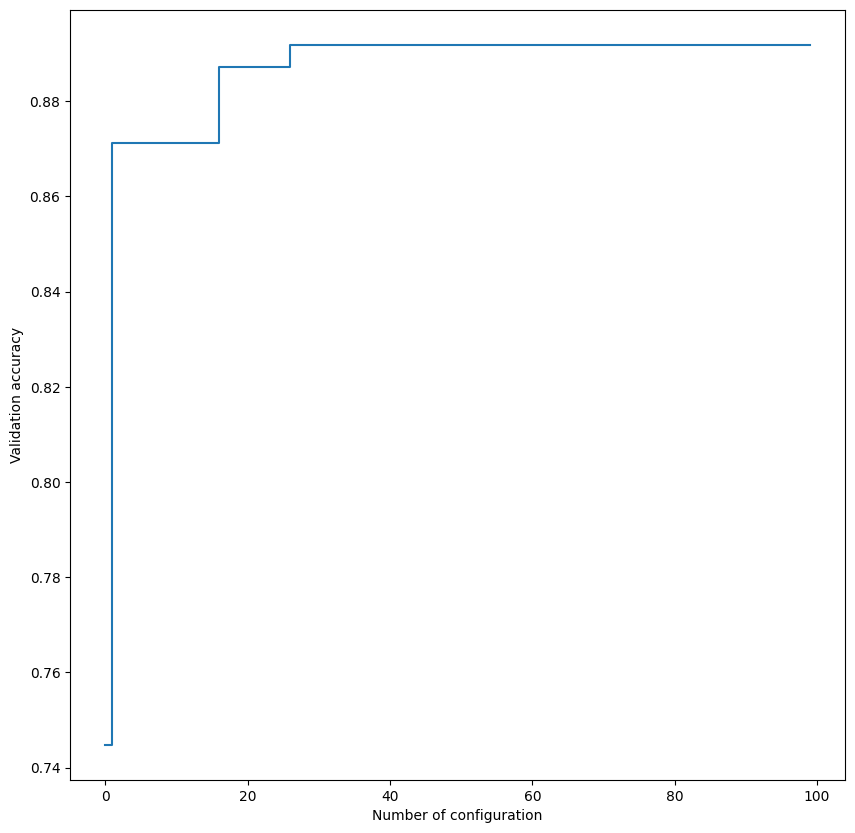

In [207]:
# Plot the incumbent improvement
plot_incumbent_improvement(history, figsize=(10, 10))

In [167]:
# Initialize the model
model = MLP(**best_cfg, random_state=random_state)

# Train the model
training_losses = model.fit(X_train, y_train)

# Get the accuracy of the model
y_pred = model.predict(X_test)

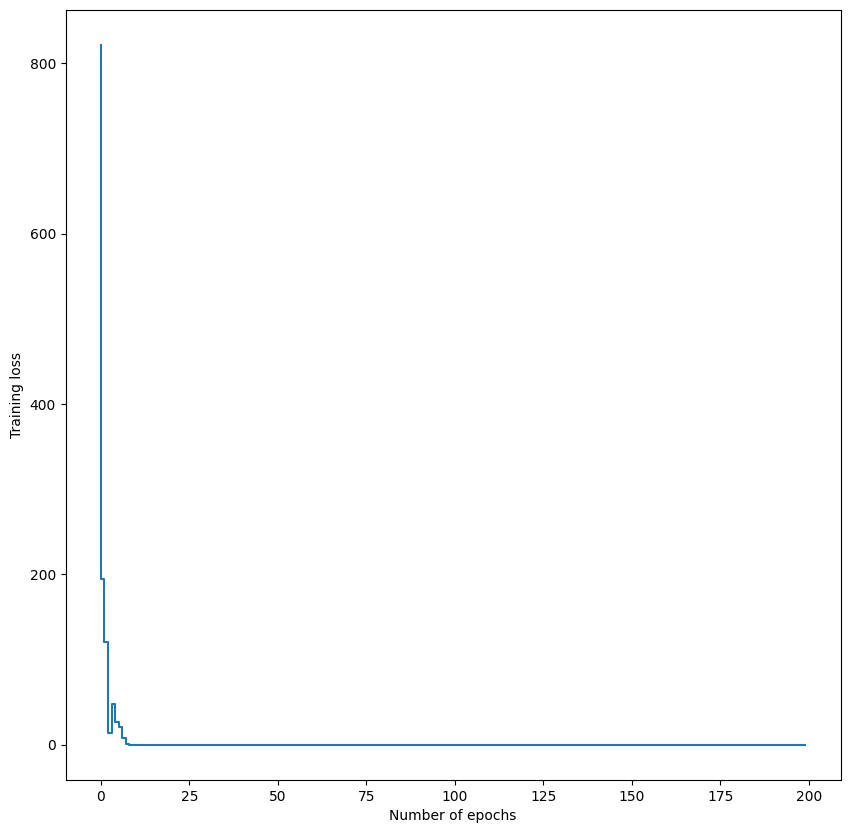

In [168]:
# Plot the learning curve
plot_learning_curve(training_losses, figsize=(10, 10))

In [169]:
# Print the balanced accuracy, f1_score and roc_auc_score
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")

print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")
print(f"F1 Score: {f1}")

Accuracy Score: 0.8305084745762712
Balanced Accuracy Score: 0.83564680933102
F1 Score: 0.8307788218016156


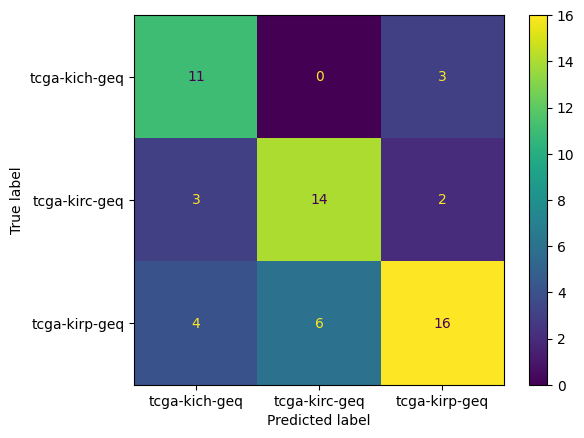

In [210]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=labels)